<a href="https://colab.research.google.com/github/nikitaghadge495/CodSoft/blob/main/task4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/content/spam.csv', encoding="ISO-8859-1")

In [3]:
df = pd.DataFrame(data)

In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
# Removing 'Unnamed' columns.
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [6]:
# Renaming columns 'v1' and 'v2' into 'target' and 'text'.
df.rename(columns={'v1': 'target', 'v2': 'text'}, inplace=True)

In [7]:
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
df.shape

(5572, 2)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [10]:
df['target'].unique()

array(['ham', 'spam'], dtype=object)

In [11]:
len(df['text'].unique())

5169

In [12]:
# Counting the occurrences of each category in 'target' column.
category_counts = df['target'].value_counts()
print(category_counts)

target
ham     4825
spam     747
Name: count, dtype: int64


In [14]:
df.describe()

,target,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [15]:
# Observing ratio of 'spam' vs 'ham', with the help of bar plot using Plotly.
fig = px.bar(category_counts, x=category_counts.index, y=category_counts.values,
             labels={'x': 'Category', 'y': 'Count'},
             title='Ratio of Spam vs Ham')
fig.show()

In [19]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [20]:
def add_text_length_features(df):
    df['num_characters'] = df['text'].apply(len)
    df['num_words'] = df['text'].apply(lambda text: len(word_tokenize(text)))
    df['num_sentences'] = df['text'].apply(lambda text: len(sent_tokenize(text)))
    return df

In [21]:
# Adding text length features to the DataFrame.
df = add_text_length_features(df)

In [22]:
# Displaying summary statistics.
text_length_stats = df[['num_characters', 'num_words', 'num_sentences']].describe()
print(text_length_stats)

       num_characters    num_words  num_sentences
count     5572.000000  5572.000000    5572.000000
mean        80.118808    18.699390       1.996411
std         59.690841    13.741932       1.520159
min          2.000000     1.000000       1.000000
25%         36.000000     9.000000       1.000000
50%         61.000000    15.000000       1.500000
75%        121.000000    27.000000       2.000000
max        910.000000   220.000000      38.000000


In [23]:
# Summary Statistics for Legitimate Emails.
ham_stats = df[df['target'] == 'ham'][['num_characters', 'num_words', 'num_sentences']].describe()
print("\nSummary Statistics for Legitimate Messages (Ham)")
print(ham_stats)


Summary Statistics for Legitimate Messages (Ham)
       num_characters    num_words  num_sentences
count     4825.000000  4825.000000    4825.000000
mean        71.023627    17.276269       1.837720
std         58.016023    13.988585       1.454388
min          2.000000     1.000000       1.000000
25%         33.000000     8.000000       1.000000
50%         52.000000    13.000000       1.000000
75%         92.000000    22.000000       2.000000
max        910.000000   220.000000      38.000000


In [24]:
# Summary Statistics for Spam Emails.
spam_stats = df[df['target'] == 'spam'][['num_characters', 'num_words', 'num_sentences']].describe()
print("\nSummary Statistics for Spam Messages")
print(spam_stats)


Summary Statistics for Spam Messages
       num_characters   num_words  num_sentences
count      747.000000  747.000000     747.000000
mean       138.866131   27.891566       3.021419
std         29.183082    6.867007       1.537580
min         13.000000    2.000000       1.000000
25%        132.500000   25.000000       2.000000
50%        149.000000   29.000000       3.000000
75%        157.000000   32.000000       4.000000
max        224.000000   46.000000       9.000000


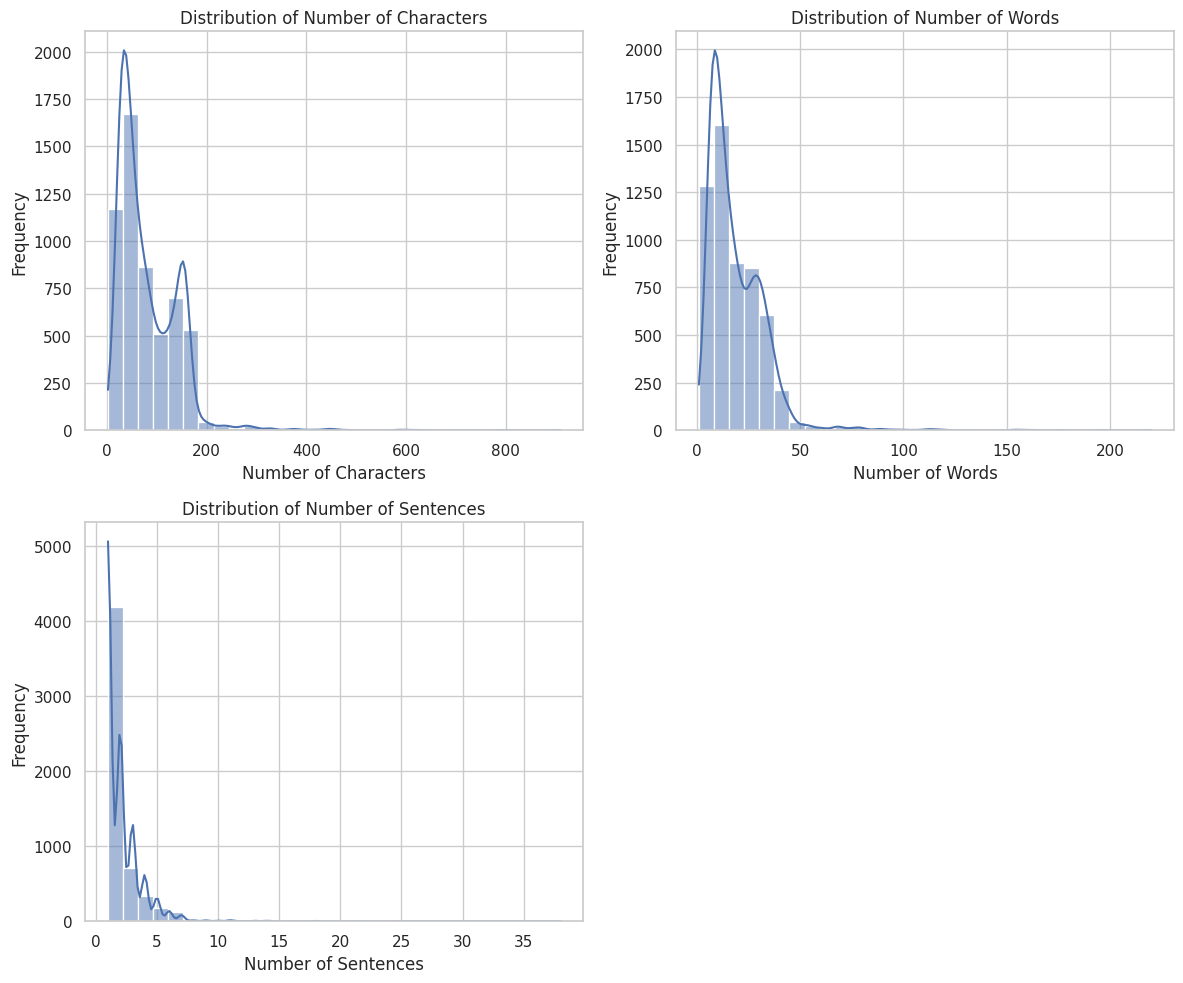

In [25]:
# Setting visual theme.
sns.set(style="whitegrid")

# Ploting histograms for text length features.
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# For number of characters.
sns.histplot(df['num_characters'], bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Number of Characters')
axes[0, 0].set_xlabel('Number of Characters')
axes[0, 0].set_ylabel('Frequency')
# For number of words.
sns.histplot(df['num_words'], bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Number of Words')
axes[0, 1].set_xlabel('Number of Words')
axes[0, 1].set_ylabel('Frequency')

# For number of sentences.
sns.histplot(df['num_sentences'], bins=30, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Number of Sentences')
axes[1, 0].set_xlabel('Number of Sentences')
axes[1, 0].set_ylabel('Frequency')

# Hiding the empty subplot (bottom right).
axes[1, 1].axis('off')

# Displaying.
plt.tight_layout()
plt.show()


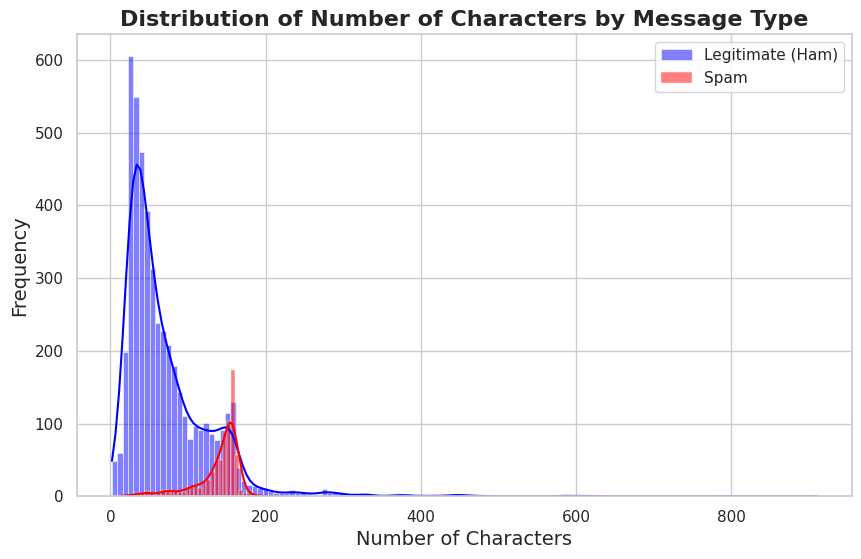

In [26]:
# Character Length Distribution for Legitimate and Spam Messages.
plt.figure(figsize=(10, 6))

# Ploting histogram for legitimate emails (ham).
sns.histplot(df[df['target'] == 'ham']['num_characters'], color='blue', label='Legitimate (Ham)', kde=True)

# Ploting the histogram for spam emails.
sns.histplot(df[df['target'] == 'spam']['num_characters'], color='red', label='Spam', kde=True)

plt.xlabel('Number of Characters', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Number of Characters by Message Type', fontsize=16, fontweight='bold')

plt.legend()
sns.set(style='whitegrid')

plt.show()


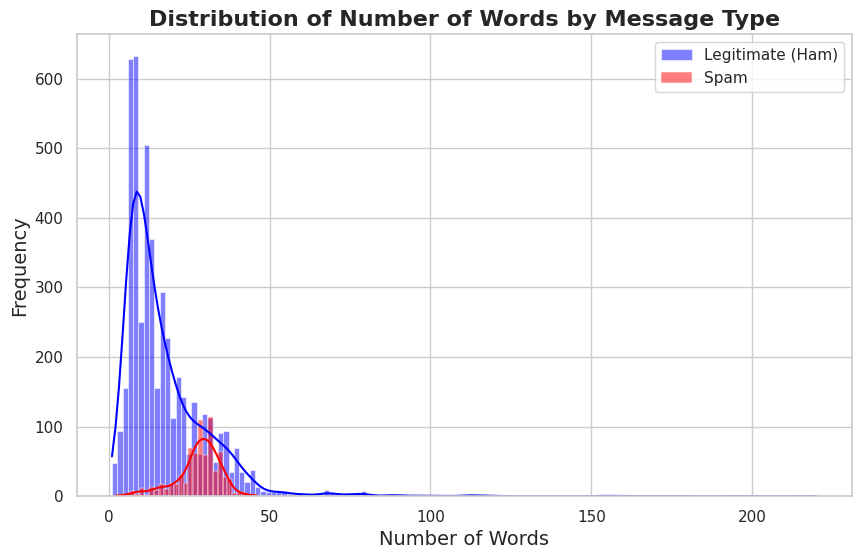

In [27]:
# Word Counts Distribution for Legitimate and Spam Messages.
plt.figure(figsize=(10, 6))

# Plot the histogram for legitimate messages (ham) in blue.
sns.histplot(df[df['target'] == 'ham']['num_words'], color='blue', label='Legitimate (Ham)', kde=True)

# Plot the histogram for spam messages in red.
sns.histplot(df[df['target'] == 'spam']['num_words'], color='red', label='Spam', kde=True)

plt.xlabel('Number of Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Number of Words by Message Type', fontsize=16, fontweight='bold')

plt.legend()

sns.set(style='whitegrid')

plt.show()

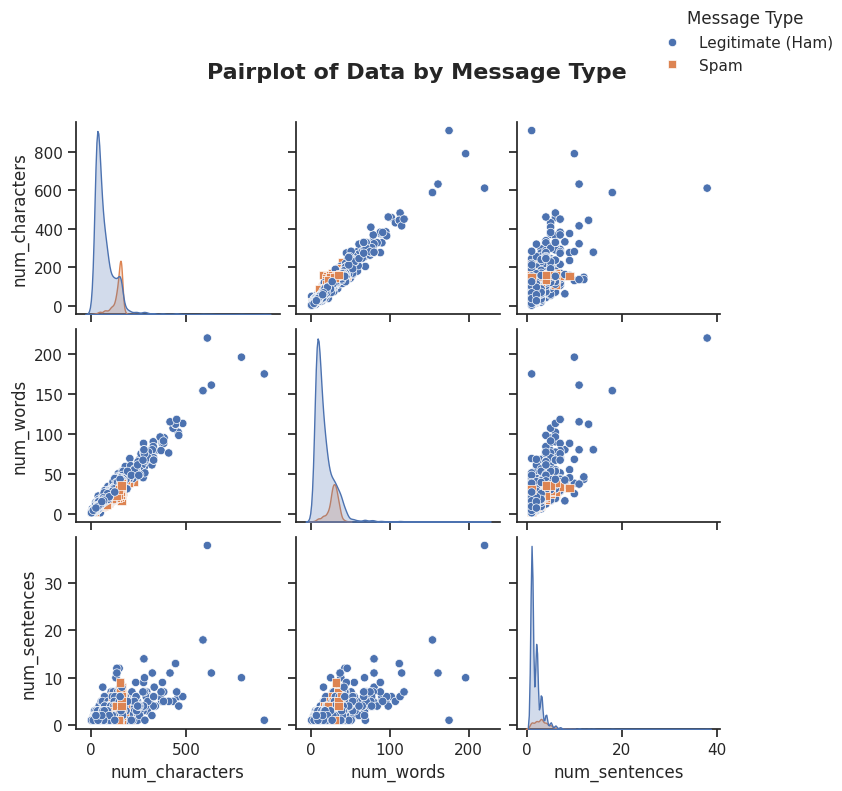

In [28]:
# Pairplots of Data Based on Target.
sns.set(style='ticks', color_codes=True)
g = sns.pairplot(df, hue='target', diag_kind='kde', markers=["o", "s"],
                 vars=['num_characters', 'num_words', 'num_sentences'])

g.fig.suptitle("Pairplot of Data by Message Type", fontsize=16, fontweight='bold')
plt.subplots_adjust(top=0.9)

g._legend.set_title('Message Type')
for t, l in zip(g._legend.texts, ["Legitimate (Ham)", "Spam"]):
    t.set_text(l)

# Adjusting legend position.
g._legend.set_bbox_to_anchor([1, 1])

plt.show()

In [29]:
# Label encoding the target column.
label_encoder = LabelEncoder()
df['target_encoded'] = label_encoder.fit_transform(df['target'])

In [30]:
# Computing correlation matrix for the specified columns.
correlation_matrix = df[['target_encoded', 'num_characters', 'num_words', 'num_sentences']].corr()
correlation_matrix

,target_encoded,num_characters,num_words,num_sentences
target_encoded,1.000000,0.387285,0.263221,0.265332
num_characters,0.387285,1.000000,0.966310,0.631881
num_words,0.263221,0.966310,1.000000,0.685165
num_sentences,0.265332,0.631881,0.685165,1.000000


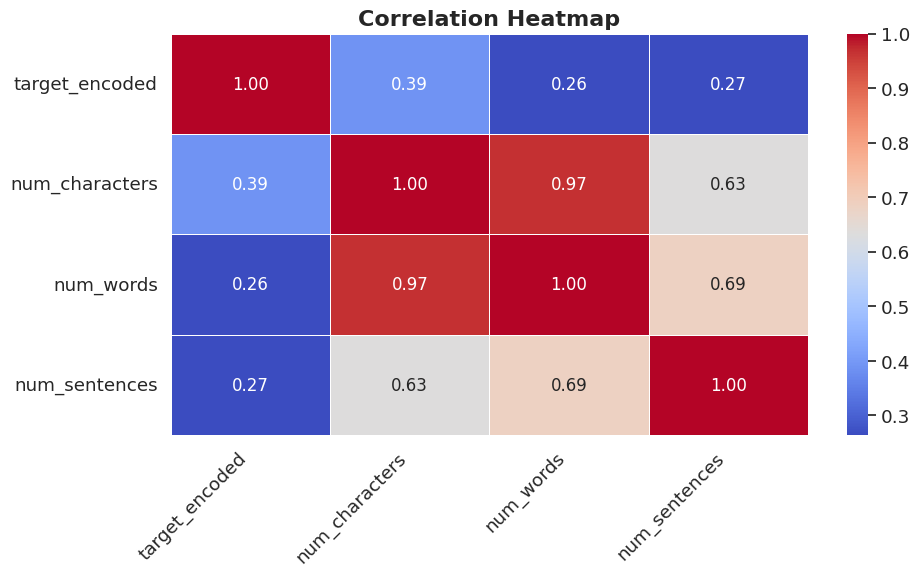

In [32]:
# Creating a heatmap.
plt.figure(figsize=(10, 6))
sns.set_theme(style='whitegrid', font_scale=1.2)
# Drawing heatmap.
heatmap = sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    linewidths=0.5,
    fmt=".2f",
    annot_kws={"size": 12}
)
# Adding title and ticks etc.
plt.title("Correlation Heatmap", fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Displaying heatmap.
plt.tight_layout()
plt.show()

In [33]:
# Function for converting text to lowercase.
def convert_to_lowercase(text):
    return text.lower()

In [34]:
# Function for removing punctuations.
def remove_punctuations(text):
    return re.sub(r'[^\w\s]', '', text)

In [35]:
# Function for removing repeated characters.
def remove_repeating_characters(text):
    return re.sub(r'(\w)\1+', r'\1', text)

In [36]:
# Function for removing URL's.
def remove_urls(text):
    return re.sub(r'http\S+', '', text)

In [37]:
# Function for removing numerical numbers.
def remove_numerical_numbers(text):
    return re.sub(r'\d+', '', text)

In [39]:
# Function for removing stop words.
def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

In [40]:
# Function for tokenization and stemming.
def preprocess_text(text):
    ps = PorterStemmer()
    tokens = [ps.stem(word) for word in text.split()]
    return ' '.join(tokens)

In [41]:
# Creating a list of all cleaning functions.
cleaning_functions = [
    convert_to_lowercase,
    remove_punctuations,
    remove_repeating_characters,
    remove_urls,
    remove_numerical_numbers,
    remove_stop_words,
    preprocess_text
]

In [43]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [44]:
# Applying each cleaning function on the data from the list through a for loop.
for func in cleaning_functions:
    df['text'] = df['text'].apply(func)

In [45]:
df.head()

,target,text,num_characters,num_words,num_sentences,target_encoded
0,ham,go jurong point crazi avail bugi n great world...,111,24,2,0
1,ham,ok lar joke wif u oni,29,8,2,0
2,spam,fre entri wkli comp win fa cup final tkt st ma...,155,37,2,1
3,ham,u dun say earli hor u c alreadi say,49,13,1,0
4,ham,nah dont think goe usf live around though,61,15,1,0


In [46]:
# Initializing WordCloud object with custom settings.
wc = WordCloud(width=1200, height=600, min_font_size=10, background_color='white')

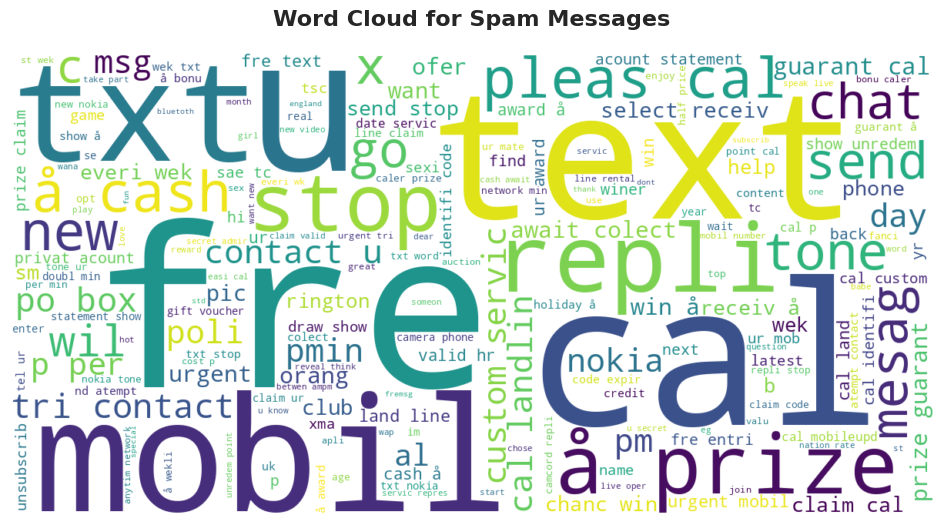

In [47]:
# Word cloud for spam emails.
spam_wc = wc.generate(df[df['target'] == 'spam']['text'].str.cat(sep=" "))
plt.figure(figsize=(15, 6))
plt.title('Word Cloud for Spam Messages', fontsize=16, fontweight='bold', pad=20)
plt.imshow(spam_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

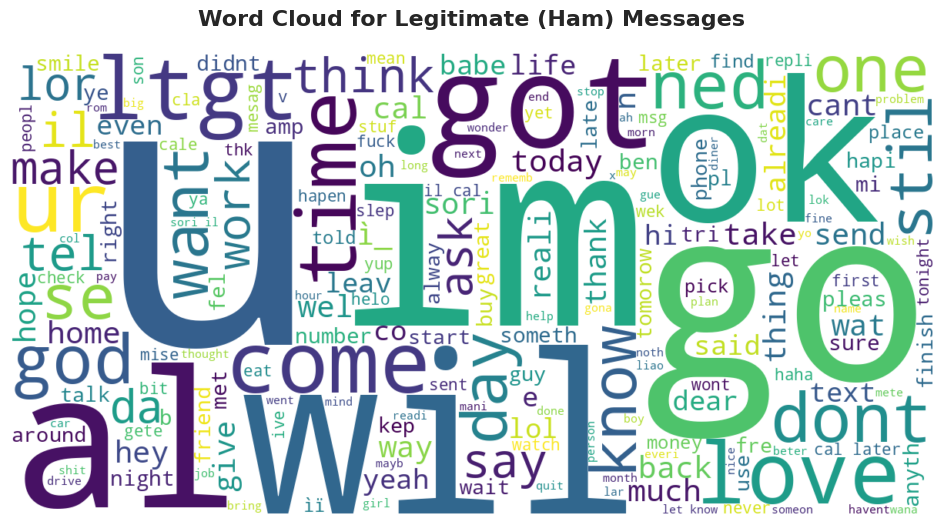

In [48]:
# Word cloud for legitimate (ham) emails.
ham_wc = wc.generate(df[df['target'] == 'ham']['text'].str.cat(sep=" "))
plt.figure(figsize=(15, 6))
plt.title('Word Cloud for Legitimate (Ham) Messages', fontsize=16, fontweight='bold', pad=20)
plt.imshow(ham_wc, interpolation='bilinear')
plt.axis('off')
plt.show()


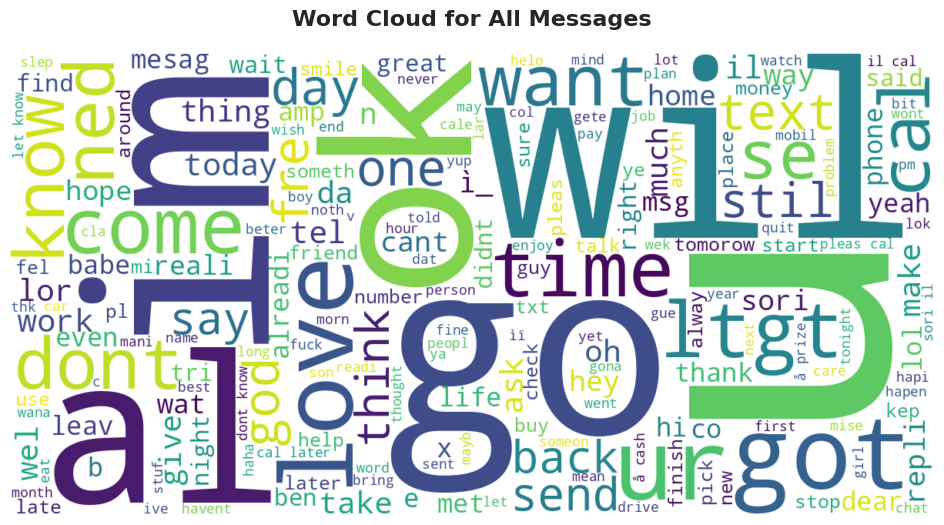

In [49]:
# Word cloud for the entire text.
all_wc = wc.generate(df['text'].str.cat(sep=" "))
plt.figure(figsize=(15, 6))
plt.title('Word Cloud for All Messages', fontsize=16, fontweight='bold', pad=20)
plt.imshow(all_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [50]:
# Initializing vectorizer.
vectorizer = TfidfVectorizer()

In [51]:
# Transforming text data.
X_text = vectorizer.fit_transform(df['text'])
X_features = df[['num_characters', 'num_words', 'num_sentences']].values
X = np.hstack((X_text.toarray(), X_features))

In [52]:
# Defining target.
y = df['target_encoded']

In [53]:
# Spliting data into test-train sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
# Initialize the models.
models = [
    ('lr', LogisticRegression(max_iter=1000)),
    ('nb', MultinomialNB()),
    ('svc', SVC(probability=True)),
    ('dt', DecisionTreeClassifier()),
    ('rf', RandomForestClassifier())
]

In [55]:
# Initialize the models.
models = [
    ('lr', LogisticRegression(max_iter=1000)),
    ('nb', MultinomialNB()),
    ('svc', SVC(probability=True)),
    ('dt', DecisionTreeClassifier()),
    ('rf', RandomForestClassifier())
]


In [56]:
# Ensemble initialized models using VotingClassifier.
ensemble_model = VotingClassifier(estimators=models, voting='soft')

In [57]:
# Training the ensembled model.
ensemble_model.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(max_iter=1000)),
                             ('nb', MultinomialNB()),
                             ('svc', SVC(probability=True)),
                             ('dt', DecisionTreeClassifier()),
                             ('rf', RandomForestClassifier())],
                 voting='soft')

In [58]:
# Predictions.
y_pred = ensemble_model.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [59]:
# Evaluating the model.
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
# Printing Plain Text Results.
print(f'Accuracy: {accuracy}\n')
print('Classification Report:')
print(classification_rep)
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.967713004484305

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       0.99      0.77      0.86       150

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.97      1115

Confusion Matrix:
[[964   1]
 [ 35 115]]


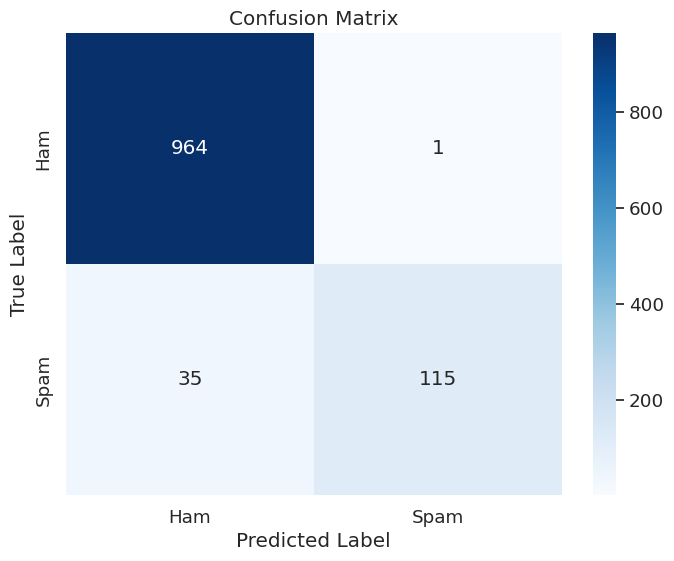

In [60]:
# Ploting Confusion Matrix Heatmap.
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [61]:
# Calculating feature importances.
feature_importances = np.mean([
    model.feature_importances_ if hasattr(model, 'feature_importances_') else np.zeros(X_train.shape[1])
    for model in ensemble_model.estimators_
], axis=0)

In [62]:
# Getting feature names.
feature_names = vectorizer.get_feature_names_out().tolist() + ['num_characters', 'num_words', 'num_sentences']

In [63]:
# Storing feature names and their importances in a new DataFrame.
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

In [64]:
# Sorting by importance and getting top 20 features.
top_features = importance_df.sort_values(by='Importance', ascending=False).head(20)

In [65]:
# Displaying top 20 features with their importance values.
print("Top 20 Feature Importances:")
print(top_features)

Top 20 Feature Importances:
             Feature  Importance
6985  num_characters    0.065448
6986       num_words    0.034493
810              cal    0.021454
6220             txt    0.019196
1042           claim    0.009072
5909            text    0.007716
3726           mobil    0.007122
2130             fre    0.006642
5172          servic    0.006076
6664             win    0.005938
6098            tone    0.005322
5628            stop    0.004850
6987   num_sentences    0.004515
4950         rington    0.004494
4889           repli    0.004008
405            award    0.003892
952             chat    0.003314
4626           prize    0.003074
4477            pmin    0.003069
3935             new    0.002998


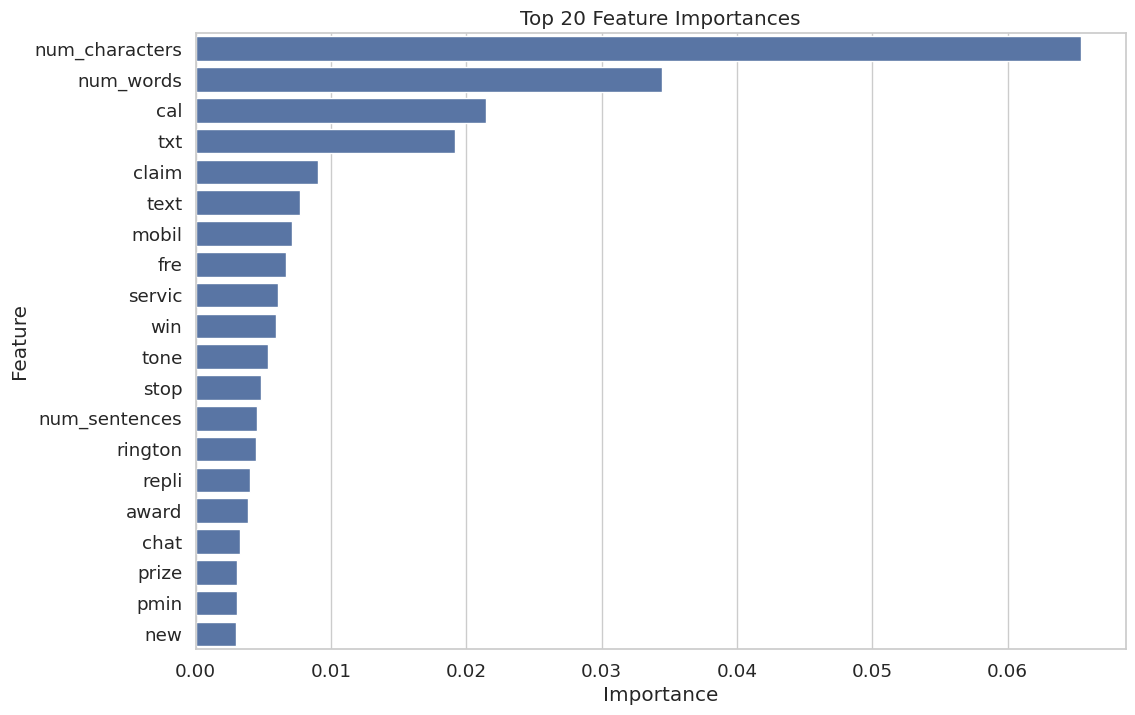

In [66]:
# Ploting top 20 feature importances.
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 20 Feature Importances')
plt.show()